# Milestone II Unsupervised Learning Component

### From project proposal:

The sport of basketball traditionally has teams composed of five positions, each with their own relatively different functions and attributes. As the game has evolved, however, these positions have become increasingly blurred. While players still have standard position labels, they are not necessarily indicative of a player’s function on their team. The goal of the unsupervised learning portion of this project is to cluster NBA players based on their on court contributions to the team. This clustering will be done using data from https://www.nbastuffer.com/player-stats/ , which lists season-long statistics for NBA players from 2008 through the present. The 2018-2019 and 2019-2020 seasons are available for free download, so these two seasons will be used. If it is necessary to include more data, several more seasons may be purchased. Each season has a XLSX (Excel spreadsheet) file for both the regular season and the playoffs, so these data sets will have to be combined.  The data is fairly clean overall, however combining each year means that many players will appear multiple times. Each of these repeated players will be treated as separate players, as function on a team may change from year to year. The same will go for players who were traded midseason. Results could be skewed by players with very little playing time, so a minimum amount of minutes per game and games played will likely be enforced. 

Two different approaches will be used to cluster the data. The first approach will be k-means clustering. The clustering will be repeated with different K values, evaluating the quality of each set of clustering using the Davie-Bouldin and Calinski-Harabasz scores. The second approach will be hierarchical clustering, and the same evaluation metrics will be used. In terms of visualizations, a dendrogram will be used to show the structure of the hierarchical clustering, while the k-means clustering will likely be put through some kind of dimensional reduction (likely t-SNE) and graphed in a 2D scatter plot. The feature representations for this project will be vectors characterizing several statistics for each player. One will likely be a subset of the other, where the superset includes metrics referring to the players physical stature, while the subset will likely only contain statistics that relate to performance on the court. 


## Imports

In [66]:
import sys
!{sys.executable} -m pip install openpyxl

In [67]:
import sys
!{sys.executable} -m pip install altair

In [68]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
from itertools import islice
#from openpyxl import DataFrame
import sklearn
import matplotlib.pyplot as plt
import altair as alt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as ch_score
from sklearn.metrics import davies_bouldin_score as db_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet


RANDOM_SEED = 42

## Cleaning the Data

Links containing the data:

    "content/2018-2019 NBA Player Stats Playoffs.xlsx"
    "content/2018-2019 NBA Player Stats Regular Season.xlsx"
    "content/2019-2020 NBA Player Stats.xlsx"

In [69]:
def gen_ids(df):
    ids = []
    for i in range(len(df)):
        num = str(i)
        ids.append((3-len(num))*'0'+num)
    return ids

In [70]:
# df = pd.read_excel('content/2019-2020 NBA Player Stats.xlsx')
# df


wb = load_workbook('content/2018-2019 NBA Player Stats Regular Season.xlsx')
ws = wb.active
#pd.DataFrame(wb2.Sheet1.values)
df = pd.DataFrame(ws.values)
curr_cols = [i for i in range(29)]
new_cols = df.iloc[1].values
names = df[[1]]
names = names.iloc[2:]
df = df.iloc[2:]
df[0] = gen_ids(df)
df = df[df[5] >= 10] # filter out players who played less than 10 games
df = df[df[6] > 20] # filter out those who played less than 20 minutes per game
df1 = df[[5,6,10,12,13,14,15,16,17,18,19,21,23,24,25,26,27,28]] # per game stuff
df2 = df[[5,6,10,12,13,14,15,16,17,18,20,22,23,24,9,26,27,28]] # % stuff
df3 = df[[18,20,22,23,24,9]] # experimenting with dif col combos
df1 = df1.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})
df1 = df1.rename(columns={'RANK':'ID'})
df2 = df2.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})
df2 = df2.rename(columns={'RANK':'ID'})


df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
5,003,Steven Adams,Okc,C,25.73,80,33.4,69.5,16.4,12.8,...,9.5,14.7,1.6,6.6,1.49,0.96,1.73,7.1,119.9,102.7
6,004,Bam Adebayo,Mia,C-F,21.73,82,23.3,48.6,15.8,17.1,...,7.3,16.6,2.2,14.2,0.88,0.79,1.48,9,120,97.2
9,007,LaMarcus Aldridge,San,F,33.73,81,33.2,69.1,27,8.8,...,9.2,15.1,2.4,11.6,0.54,1.32,1.78,9.4,117.8,106.4
12,010,Jarrett Allen,Bro,C,20.97,80,26.2,54.6,15.9,13.1,...,8.4,16.9,1.4,7.9,0.54,1.5,1.3,7.7,123.8,101.5
13,011,Kadeem Allen,Nyk,G,26.24,19,21.9,45.6,19.6,14.2,...,2.7,6.4,4,28.8,0.84,0.21,1.42,8.7,116.2,105.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,611,Delon Wright,Mem,G,26.96,26,30.8,64.3,19.2,11.6,...,5.5,9.9,5.3,26.9,1.62,0.58,1.54,9.2,111.2,105.1
616,614,Thaddeus Young,Ind,F,30.8,81,30.7,64,18,12,...,6.4,11.6,2.5,12,1.52,0.47,1.52,7.6,113.6,101.6
617,615,Trae Young,Atl,G,20.56,81,30.9,64.4,28.4,17.6,...,3.7,6.3,8.1,40.5,0.86,0.19,3.8,10.7,107.5,114.2
618,616,Cody Zeller,Cha,F-C,26.51,49,25.4,52.8,16.2,13,...,6.8,14.4,2.1,12.2,0.78,0.86,1.24,8.3,123.7,100.3


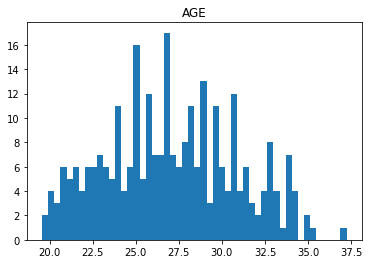

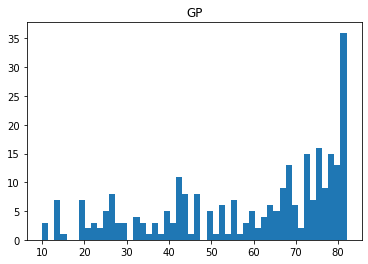

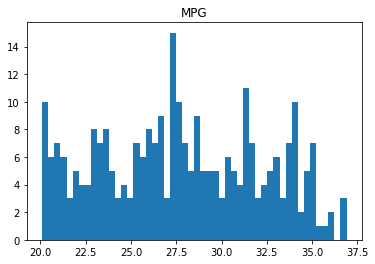

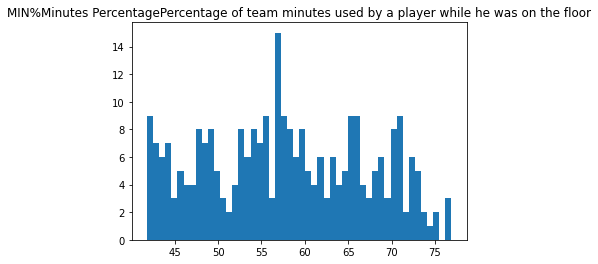

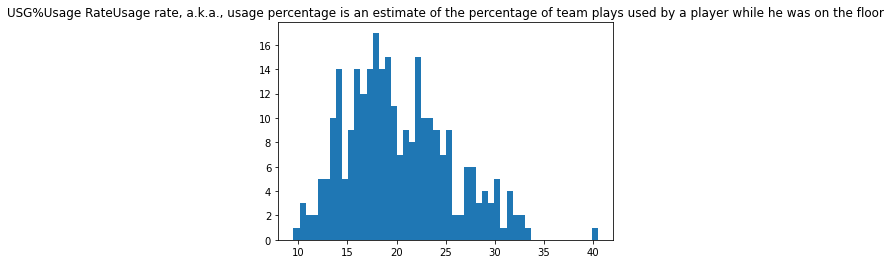

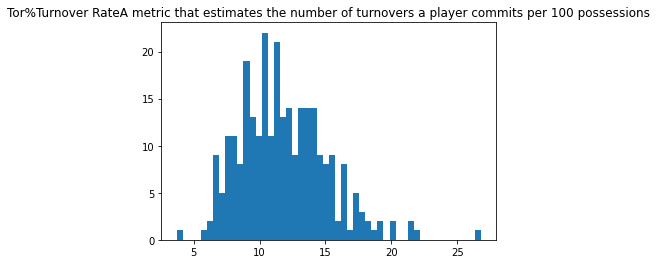

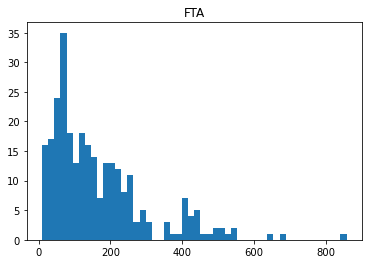

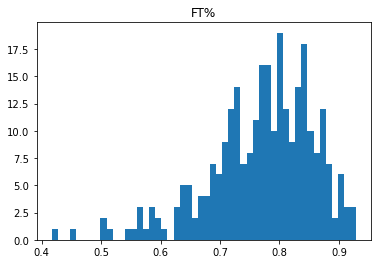

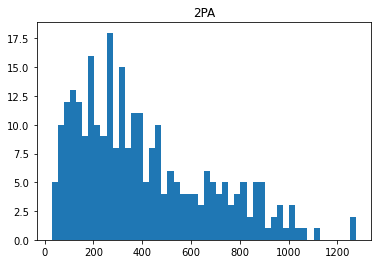

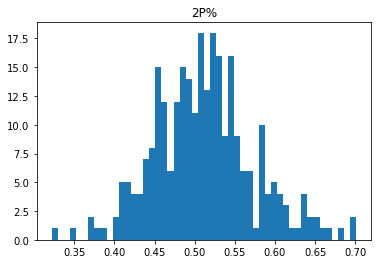

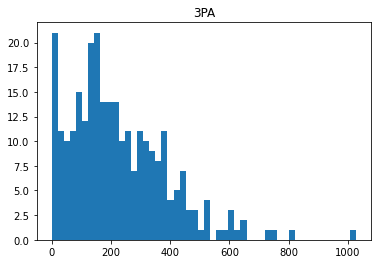

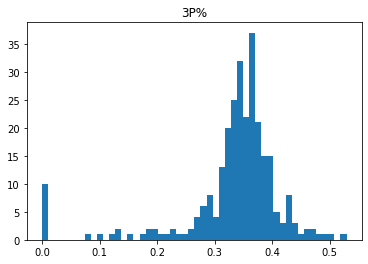

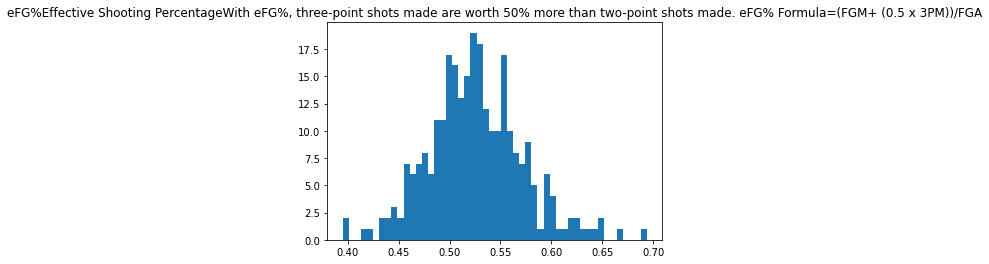

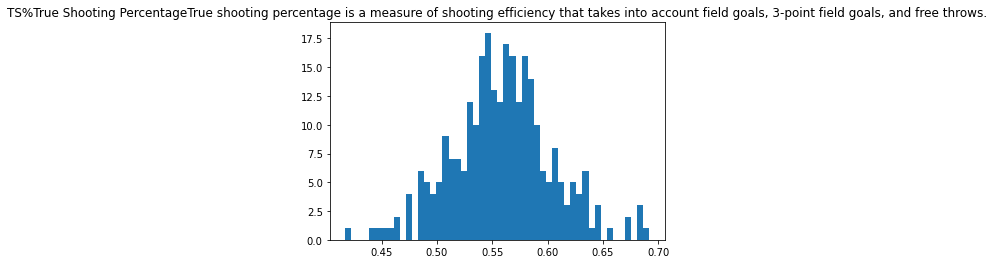

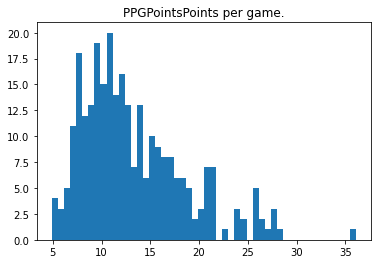

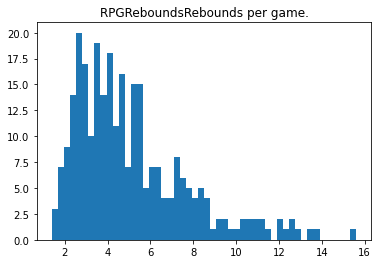

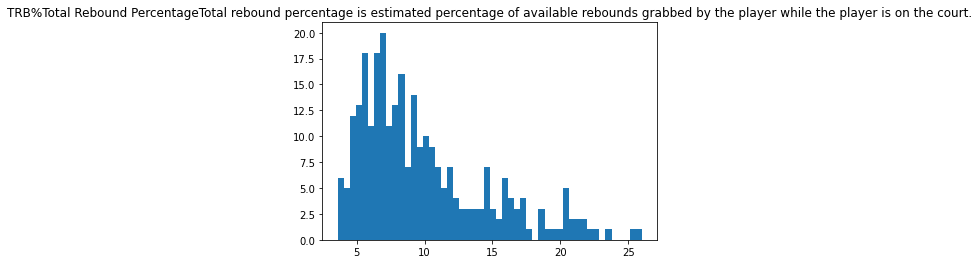

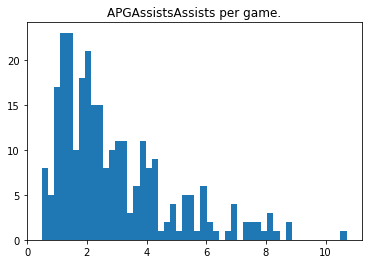

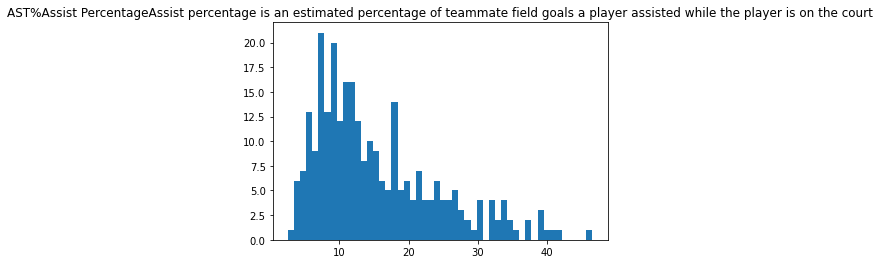

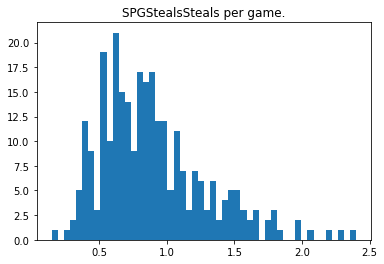

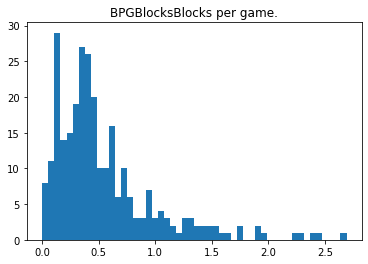

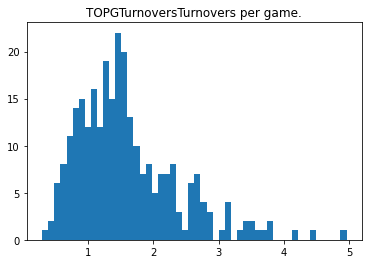

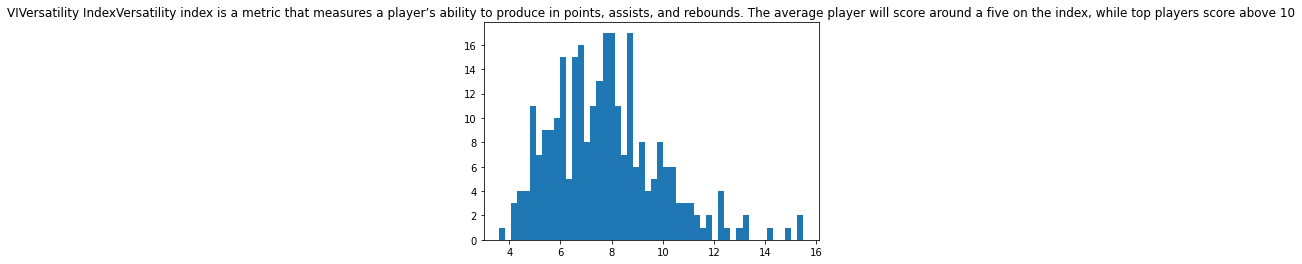

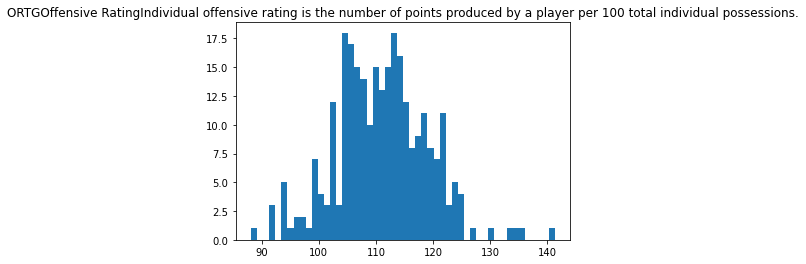

In [71]:
df = df[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
df = df.dropna()
# df = df[df[26] > 5]
for col in df.columns:
    plt.hist(df[col].values, bins=50)
    plt.title(new_cols[col])
    plt.show()

## First Attempt Clustering (Kmeans)

In [72]:
def try_n_clusters(df, N=30):
#     scaler = StandardScaler()
#     scaled_vals = scaler.fit_transform(df.values)
    
    ch_scores = []
    db_scores = []
    for n in range(2,N):
        clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
        clus.fit(scaled_vals)
        cluster_labels = clus.labels_
        ch_scores.append(ch_score(scaled_vals, cluster_labels))
        db_scores.append(db_score(scaled_vals, cluster_labels))
    fig, ax = plt.subplots(1,2)
    ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
    ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
    plt.show()

#try_n_clusters(df1, 12)

In [73]:
#try_n_clusters(df2, 100)

In [74]:
#try_n_clusters(df3, 50)

In [75]:
# df1_labeled = df1
# df1_labeled['cluster'] = cluster_labels
# df1_labeled['player'] = df[1]
# df1_labeled

A couple thoughts:
1. Check out the n=2 clusters. What are the avg values for each attribute?? Do we need to filter out more players?
2. Do we need way more clusters?
3. Should we narrow way down on players? Maybe look at just the top players and find types, then look at only lower tier players and find clusters there too?
4. Try reducing the dimensions??

In [76]:
clus = KMeans(n_clusters=2, random_state=RANDOM_SEED)
clus.fit(df2.values)
cluster_labels = clus.labels_

df2_labeled = df2
df2_labeled['cluster'] = cluster_labels
#df2_labeled['player'] = df[1]
df2_labeled

,GP,MPG,FTA,2PA,2P%,3PA,3P%,"eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA","TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.",PPGPointsPoints per game.,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,DRTGDefensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court.,cluster
5,80,33.4,292,807,0.596,2,0,0.595,0.591,13.9,14.7,6.6,1.49,0.96,12.8,7.1,119.9,102.7,0
6,82,23.3,226,471,0.588,15,0.2,0.579,0.623,8.9,16.6,14.2,0.88,0.79,17.1,9,120,97.2,1
9,81,33.2,412,1277,0.528,42,0.238,0.522,0.576,21.3,15.1,11.6,0.54,1.32,8.8,9.4,117.8,106.4,0
12,80,26.2,278,523,0.629,45,0.133,0.595,0.632,10.9,16.9,7.9,0.54,1.5,13.1,7.7,123.8,101.5,1
13,19,21.9,54,104,0.462,36,0.472,0.525,0.577,9.9,6.4,28.8,0.84,0.21,14.2,8.7,116.2,105.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,26,30.8,89,187,0.508,78,0.256,0.472,0.519,12.2,9.9,26.9,1.62,0.58,11.6,9.2,111.2,105.1,1
616,81,30.7,135,696,0.563,146,0.349,0.556,0.568,12.6,11.6,12,1.52,0.47,12,7.6,113.6,101.6,0
617,81,30.9,414,775,0.476,482,0.324,0.48,0.538,19.1,6.3,40.5,0.86,0.19,17.6,10.7,107.5,114.2,0
618,49,25.4,141,323,0.57,22,0.273,0.559,0.611,10.1,14.4,12.2,0.78,0.86,13,8.3,123.7,100.3,1


In [77]:
group1 = df2_labeled[df2_labeled['cluster']==1]
group0 = df2_labeled[df2_labeled['cluster']==0]

group1_mean = group1.mean(axis=0).to_frame().transpose() # mean values of each cluster
group0_mean = group0.mean(axis=0).to_frame().transpose()
means = group0_mean.append(group1_mean).reset_index()
means

,index,GP,MPG,FTA,2PA,2P%,3PA,3P%,"eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA","TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.",PPGPointsPoints per game.,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,DRTGDefensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court.,cluster
0,0,73.708861,31.505063,330.810127,771.455696,0.52643,314.974684,0.319329,0.534418,0.573658,19.288608,11.297468,19.749367,1.018481,0.717595,11.739241,9.455696,113.308861,104.929114,0.0
1,0,52.315000,26.265000,100.905000,261.845000,0.50545,189.380000,0.338900,0.522040,0.552595,10.886500,9.265000,13.706000,0.847450,0.478650,11.857500,7.088500,110.144000,105.522500,1.0


## Dimensionality Reduction

We're gonna try PCA. Not sure if we need to normalize all variables yet

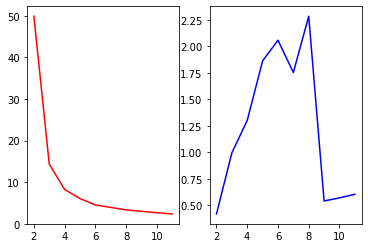

In [78]:


scaler = StandardScaler()
og_data = scaler.fit_transform(df.values)

ch_scores = []
db_scores = []
for i in range(2,12):
    pca = PCA(n_components=i)
    pca.fit(og_data)
    X = pd.DataFrame(pca.components_).transpose().values
    clus = KMeans(n_clusters=2, random_state=RANDOM_SEED)
    clus.fit(X)
    cluster_labels = clus.labels_
    ch_scores.append(ch_score(X, cluster_labels))
    db_scores.append(db_score(X, cluster_labels))
    
#print(ch_scores)

fig, ax = plt.subplots(1,2)
ax[0].plot([_ for _ in range(2,12)], ch_scores, color='r')
ax[1].plot([_ for _ in range(2,12)], db_scores, color='b')
plt.show()

## Let's try just the good players

Narrow it down to essentially just starters, maybe 6th man?

In [79]:
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(df.values)
print(scaled_vals.shape)
pca = PCA(n_components=3)
pca.fit(scaled_vals.transpose())
X = pd.DataFrame(pca.components_).transpose().values

X.shape

(279, 24)


(279, 3)

In [80]:
# ch_scores = [] 
# db_scores = []
# N = 200
# for n in range(2, N):
#     clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
#     clus.fit(scaled_vals)
#     cluster_labels = clus.labels_
#     ch_scores.append(ch_score(scaled_vals, cluster_labels))
#     db_scores.append(db_score(scaled_vals, cluster_labels))
# fig, ax = plt.subplots(1,2)
# ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
# ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
# plt.show()

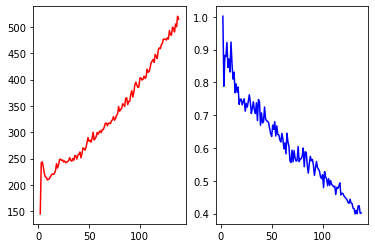

In [81]:
df4 = df[[10,12,14,20,22]] # Uses attempted shots, rebound %, assist %
df5 = df[[10,12,14,20,22,23,24]]

scaled_vals = scaler.fit_transform(df4.values)

pca = PCA(n_components=2)
pca.fit(scaled_vals.transpose())
X = pd.DataFrame(pca.components_).values.transpose()

ch_scores = []
db_scores = []
N = len(df4.index)//2
for n in range(2, N):
    clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
    clus.fit(X)
    cluster_labels = clus.labels_
    ch_scores.append(ch_score(X, cluster_labels))
    db_scores.append(db_score(X, cluster_labels))
fig, ax = plt.subplots(1,2)
ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
plt.show()

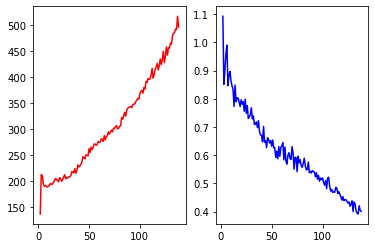

In [82]:
scaled_vals = scaler.fit_transform(df5.values)

pca = PCA(n_components=2)
pca.fit(scaled_vals.transpose())
X = pd.DataFrame(pca.components_).transpose().values

ch_scores = []
db_scores = []
N = len(df4.index)//2
for n in range(2, N):
    clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
    clus.fit(X)
    cluster_labels = clus.labels_
    ch_scores.append(ch_score(X, cluster_labels))
    db_scores.append(db_score(X, cluster_labels))
fig, ax = plt.subplots(1,2)
ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
plt.show()

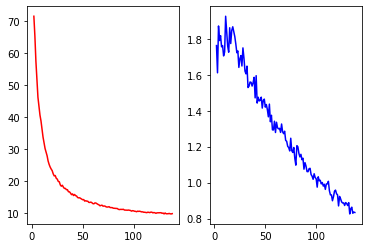

In [83]:
scaled_vals = scaler.fit_transform(df.values) # all features, scaled but not dimensionaly reduced

# pca = PCA(n_components=2)
# pca.fit(scaled_vals.transpose())
# X = pd.DataFrame(pca.components_).transpose().values

ch_scores = []
db_scores = []
N = len(df.index)//2
for n in range(2, N):
    clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
    clus.fit(scaled_vals)
    cluster_labels = clus.labels_
    ch_scores.append(ch_score(scaled_vals, cluster_labels))
    db_scores.append(db_score(scaled_vals, cluster_labels))
fig, ax = plt.subplots(1,2)
ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
plt.show()

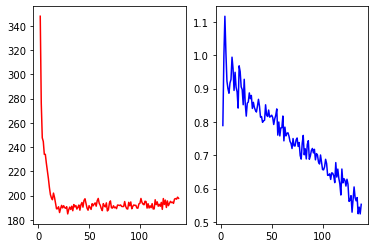

In [84]:
vals = df.values # all features, not scaled or dimensionaly reduced

ch_scores = []
db_scores = []
N = len(df.index)//2
for n in range(2, N):
    clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
    clus.fit(vals)
    cluster_labels = clus.labels_
    ch_scores.append(ch_score(vals, cluster_labels))
    db_scores.append(db_score(vals, cluster_labels))
fig, ax = plt.subplots(1,2)
ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
plt.show()

Looks like the most reasonable cluster we get is when we don't scale or do dimensionality reduction and use n=2 clusters. My guess is those 2 clusters will separate the starters from the players who get substantially less playing time. So perhaps we use those labels to further narrow down our field.

In [85]:
clus = KMeans(n_clusters=2, random_state=RANDOM_SEED)
clus.fit(vals)
df['first_cluster'] = clus.labels_
# summary_df = df.groupby('first_cluster').agg('mean')
# summary_df
group1 = df[df['first_cluster']==1]
group0 = df[df['first_cluster']==0]

group1_mean = group1.mean(axis=0).to_frame().transpose() # mean values of each cluster
group0_mean = group0.mean(axis=0).to_frame().transpose()
means = group0_mean.append(group1_mean).reset_index()
means.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,index,AGE,GP,MPG,MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor,"USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor",Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,FTA,FT%,2PA,...,RPGReboundsRebounds per game.,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,APGAssistsAssists per game.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,TOPGTurnoversTurnovers per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,first_cluster
0,0,26.388354,73.708861,31.505063,65.629114,25.496203,11.739241,330.810127,0.774456,771.455696,...,6.613924,11.297468,3.958228,19.749367,1.018481,0.717595,2.260253,9.455696,113.308861,0.0
1,0,27.341250,52.315000,26.265000,54.720000,18.142500,11.857500,100.905000,0.767980,261.845000,...,4.502500,9.265000,2.521000,13.706000,0.847450,0.478650,1.330900,7.088500,110.144000,1.0


In [86]:
means[[5,10,12,14,18,20,22,23,24,26,27]].rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,GP,FTA,2PA,3PA,PPGPointsPoints per game.,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.
0,73.708861,330.810127,771.455696,314.974684,19.288608,11.297468,19.749367,1.018481,0.717595,9.455696,113.308861
1,52.315000,100.905000,261.845000,189.380000,10.886500,9.265000,13.706000,0.847450,0.478650,7.088500,110.144000


In [87]:
group1_indices = list(group1.index)
group1_names = []
group0_names = []
for i in df.index:
    if i in group1_indices:
        group1_names.append(names.loc[i][1])
    else:
        group0_names.append(names.loc[i][1])
group0['player'] = group0_names
group1['player'] = group1_names
group0.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,AGE,GP,MPG,MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor,"USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor",Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,FTA,FT%,2PA,2P%,...,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,APGAssistsAssists per game.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,TOPGTurnoversTurnovers per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,first_cluster,player
5,25.73,80,33.4,69.5,16.4,12.8,292,0.5,807,0.596,...,14.7,1.6,6.6,1.49,0.96,1.73,7.1,119.9,0,Steven Adams
9,33.73,81,33.2,69.1,27,8.8,412,0.847,1277,0.528,...,15.1,2.4,11.6,0.54,1.32,1.78,9.4,117.8,0,LaMarcus Aldridge
20,24.35,72,32.8,68.2,32.3,14.7,686,0.729,1045,0.64,...,19.4,5.9,30.3,1.26,1.53,3.71,15.5,121.6,0,Giannis Antetokounmpo
28,20.72,71,30.7,64,21.2,11.7,189,0.746,866,0.588,...,18.5,1.8,9.6,0.87,0.94,1.77,8.7,117.7,0,Deandre Ayton
30,20.08,62,25.3,52.7,24.2,10.7,262,0.691,610,0.534,...,15.5,1,5.9,0.53,0.95,1.58,7.6,111.1,0,Marvin Bagley III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,29.83,72,23.3,48.4,22.6,10.9,243,0.449,665,0.58,...,26,0.8,5.6,0.64,1.89,1.33,8.3,112.4,0,Hassan Whiteside
599,24.13,73,34.8,72.6,24.4,9.4,296,0.699,862,0.441,...,7.4,2.5,10.9,0.97,0.66,1.9,6.9,99.8,0,Andrew Wiggins
605,32.46,75,26.6,55.4,32.5,11.8,484,0.876,847,0.447,...,5.9,5.3,33,0.75,0.15,2.41,10.3,111.8,0,Lou Williams
616,30.8,81,30.7,64,18,12,135,0.644,696,0.563,...,11.6,2.5,12,1.52,0.47,1.52,7.6,113.6,0,Thaddeus Young


In [88]:
group1.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,AGE,GP,MPG,MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor,"USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor",Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,FTA,FT%,2PA,2P%,...,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,APGAssistsAssists per game.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,TOPGTurnoversTurnovers per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,first_cluster,player
6,21.73,82,23.3,48.6,15.8,17.1,226,0.735,471,0.588,...,16.6,2.2,14.2,0.88,0.79,1.48,9,120,1,Bam Adebayo
12,20.97,80,26.2,54.6,15.9,13.1,278,0.709,523,0.629,...,16.9,1.4,7.9,0.54,1.5,1.3,7.7,123.8,1,Jarrett Allen
13,26.24,19,21.9,45.6,19.6,14.2,54,0.778,104,0.462,...,6.4,4,28.8,0.84,0.21,1.42,8.7,116.2,1,Kadeem Allen
14,28.55,81,28.3,58.9,13.7,9.7,173,0.867,313,0.514,...,14.2,1.3,6,0.84,0.41,0.89,6.4,118.3,1,Al-Farouq Aminu
16,25.56,43,29.8,62.1,12.6,16,64,0.578,242,0.583,...,11,3,15,1.26,0.86,1.35,7,110.8,1,Kyle Anderson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,32.81,75,28.4,59.3,14.9,6.3,86,0.767,270,0.5,...,10.3,1.2,6.1,0.92,0.8,0.61,5.7,112.7,1,Marvin Williams
609,23.04,66,29.7,61.9,20.8,14.9,137,0.628,493,0.462,...,9.6,4.3,21.9,1.09,0.29,2.15,8.9,102.6,1,Justise Winslow
613,26.96,26,30.8,64.3,19.2,11.6,89,0.742,187,0.508,...,9.9,5.3,26.9,1.62,0.58,1.54,9.2,111.2,1,Delon Wright
618,26.51,49,25.4,52.8,16.2,13,141,0.787,323,0.57,...,14.4,2.1,12.2,0.78,0.86,1.24,8.3,123.7,1,Cody Zeller


## Alright, let's move forward with group 0

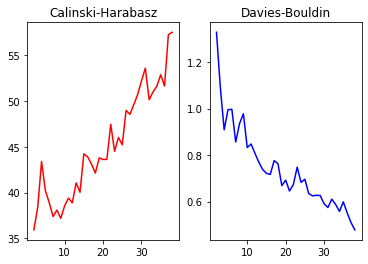

In [156]:
vals = group0.drop(columns=['first_cluster','player']).values # all features, not scaled or dimensionaly reduced

ch_scores = []
db_scores = []
N = len(group0.index)//2       # use 4 and 37 for a closer look
for n in range(2, N):
    clus = KMeans(n_clusters=n, random_state=RANDOM_SEED)
    clus.fit(vals)
    cluster_labels = clus.labels_
    ch_scores.append(ch_score(vals, cluster_labels))
    db_scores.append(db_score(vals, cluster_labels))
fig, ax = plt.subplots(1,2)
ax[0].plot([_ for _ in range(2,N)], ch_scores, color='r')
ax[1].plot([_ for _ in range(2,N)], db_scores, color='b')
ax[0].title.set_text('Calinski-Harabasz')
ax[1].title.set_text('Davies-Bouldin')
plt.show()

In the above graphs the clear best point is 37 (lowest DB, highest CH). However, 37 seems to be a very high number of clusters, especially when considering that the current group of players we are pooling from only has 79 members. There is also a large spike in the CH score with an accompanying spike in the DB score at 4. So we will take a look at both of these points.

In [90]:
group0_37 = group0

clus = KMeans(n_clusters=37, random_state=RANDOM_SEED)
clus.fit(vals)
group0_37['cluster37'] = clus.labels_
group0_37[group0_37.cluster37 == 24].rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,AGE,GP,MPG,MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor,"USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor",Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,FTA,FT%,2PA,2P%,...,APGAssistsAssists per game.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,TOPGTurnoversTurnovers per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,first_cluster,player,cluster37
173,30.53,78,34.6,72.2,29,12.2,506,0.885,995,0.587,...,5.9,26.2,0.76,1.08,2.87,11.5,120.9,0,Kevin Durant,24
569,23.4,77,33,68.9,29,13.7,450,0.836,960,0.561,...,3.4,17.2,0.88,1.62,3.13,12.2,118.5,0,Karl-Anthony Towns,24
595,30.41,73,36,75,30.9,16.2,450,0.658,1062,0.481,...,10.7,46.5,1.95,0.45,4.44,15.5,105.2,0,Russell Westbrook,24


Interesting:
1) Bradley Beal and Donovan Mitchell grouped together (cluster 2)

2) Trae Young and Luka Doncic grouped together with Mike Conley (cluster 25)

3) James Harden is in a cluster of his own w an absurd amount of FTAs (cluster 10)

4) LeBron James and Kawhi Leonard grouped with Zach LaVine and Lou Williams (cluster 20)

5) Steph Curry is in a cluster of his own (cluster 21)

6) KD is with Russell Westbrook and KAT (cluster 24)

This works decently well for comparing player production, as they do for the NBA draft or maybe when trying to prepare for facing off against a specific player. However, the goal of this project is to get a better understanding of what kind of players occupy a court at a given time. Since there can be a max of 5 players, this number clusters isn't going to cut it. Let's check out that spike at 4 clusters.

In [141]:
group0_4 = group0

clus = KMeans(n_clusters=4, random_state=RANDOM_SEED)
clus.fit(vals)
group0_4['cluster4'] = clus.labels_
group0_4[group0_4.cluster4 == 3].rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,AGE,GP,MPG,MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor,"USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor",Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,FTA,FT%,2PA,2P%,...,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,TOPGTurnoversTurnovers per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,first_cluster,player,cluster37,cluster4
9,33.73,81,33.2,69.1,27,8.8,412,0.847,1277,0.528,...,11.6,0.54,1.32,1.78,9.4,117.8,0,LaMarcus Aldridge,12,3
20,24.35,72,32.8,68.2,32.3,14.7,686,0.729,1045,0.64,...,30.3,1.26,1.53,3.71,15.5,121.6,0,Giannis Antetokounmpo,15,3
66,22.44,64,35,73,32.9,15.4,454,0.866,841,0.536,...,34.1,0.88,0.2,4.13,10.3,109.4,0,Devin Booker,5,3
146,26.09,56,33,68.8,29.5,8.5,433,0.794,881,0.547,...,19,1.57,2.41,2.02,12.9,122.1,0,Anthony Davis,8,3
157,29.68,77,34.9,72.7,27.9,11.6,439,0.831,1268,0.492,...,27.6,1.12,0.47,2.57,10.6,110,0,DeMar DeRozan,12,3
170,25.67,79,33.5,69.8,23,12.4,412,0.59,1016,0.547,...,7.2,1.73,1.76,2.22,8.6,113.1,0,Andre Drummond,0,3
173,30.53,78,34.6,72.2,29,12.2,506,0.885,995,0.587,...,26.2,0.76,1.08,2.87,11.5,120.9,0,Kevin Durant,24,3
180,25.07,64,33.7,70.1,33.3,13.3,649,0.804,936,0.535,...,18.4,0.72,1.91,3.55,13.2,113.7,0,Joel Embiid,30,3
199,21.31,81,31.4,65.5,24.5,15,417,0.727,870,0.482,...,33.2,1.64,0.56,2.8,10,109.9,0,De'Aaron Fox,8,3
241,25.21,82,26.3,54.8,23.5,11,414,0.643,871,0.623,...,12.5,0.85,1.34,1.61,9.1,122.9,0,Montrezl Harrell,26,3


In [92]:
print('CH: ', ch_score(vals, clus.labels_))
print('DB: ', db_score(vals, clus.labels_))

CH:  43.54434296477188
DB:  0.9065698503659495


Four clusters:

0: Downright scorers and athletes. All guys who can score from anywhere on the floor and aren't afraid to drive to the hole.

1: An interesting mix. A good number of big men who play strong defense and can score within 15 feet. A couple of aging, former-superstars in Dwayne Wade and Derrick Rose. Not the prolific players they were a decade ago, but still have some left in the tank. Tobias Harris and Jimmy Butler make interesting additions to the group, especially since Jimmy Butler is the type of player you want to take the last shot. I could see him in the previous group too. But for the majority, this group can score, but they can also facilitate

2: A lot of guys who are all around threats (Jayson Tatum, Kyrie, Steph, Luka), but definitely fellas who can shoot from the outside (JJ Redick, Klay Thompson, Trae Young, etc.). 

3: Maybe not all the best shooters, but these guys can certainly do work around the rim. AD, Embiid, KAT. There's also the guys who can take it to the rim on just about anyone (Russ, Ben Simmons, Kawhi, Giannis, and of course LeBron). Then there's all around scorers like Devin Booker and Collin Sexton, not to mention probably the most dangerous player in the league in Kevin Durant. 

In [93]:
group0_4 = group0_4.reset_index()

wb = load_workbook('content/2018-2019 NBA Player Stats Regular Season.xlsx')
ws = wb.active
#pd.DataFrame(wb2.Sheet1.values)
df = pd.DataFrame(ws.values)
curr_cols = [i for i in range(29)]
new_cols = df.iloc[1].values
names = df[[1]]
names = names.iloc[2:]
df = df.iloc[2:]
df[0] = gen_ids(df)
df = df[df[5] >= 10] # filter out players who played less than 10 games
df = df[df[6] > 20] # filter out those who played less than 20 minutes per game
df = df.dropna()
df = df.reset_index()
df

,index,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
0,5,003,Steven Adams,Okc,C,25.73,80,33.4,69.5,16.4,...,9.5,14.7,1.6,6.6,1.49,0.96,1.73,7.1,119.9,102.7
1,6,004,Bam Adebayo,Mia,C-F,21.73,82,23.3,48.6,15.8,...,7.3,16.6,2.2,14.2,0.88,0.79,1.48,9,120,97.2
2,9,007,LaMarcus Aldridge,San,F,33.73,81,33.2,69.1,27,...,9.2,15.1,2.4,11.6,0.54,1.32,1.78,9.4,117.8,106.4
3,12,010,Jarrett Allen,Bro,C,20.97,80,26.2,54.6,15.9,...,8.4,16.9,1.4,7.9,0.54,1.5,1.3,7.7,123.8,101.5
4,13,011,Kadeem Allen,Nyk,G,26.24,19,21.9,45.6,19.6,...,2.7,6.4,4,28.8,0.84,0.21,1.42,8.7,116.2,105.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,613,611,Delon Wright,Mem,G,26.96,26,30.8,64.3,19.2,...,5.5,9.9,5.3,26.9,1.62,0.58,1.54,9.2,111.2,105.1
275,616,614,Thaddeus Young,Ind,F,30.8,81,30.7,64,18,...,6.4,11.6,2.5,12,1.52,0.47,1.52,7.6,113.6,101.6
276,617,615,Trae Young,Atl,G,20.56,81,30.9,64.4,28.4,...,3.7,6.3,8.1,40.5,0.86,0.19,3.8,10.7,107.5,114.2
277,618,616,Cody Zeller,Cha,F-C,26.51,49,25.4,52.8,16.2,...,6.8,14.4,2.1,12.2,0.78,0.86,1.24,8.3,123.7,100.3


In [94]:
clustered_df = df.merge(group0_4, how='outer', on='index')
clustered_df = clustered_df.rename(columns={2:'team'})
clustered_df = clustered_df.dropna()
# clustered_df.sort_values(['team','cluster4'])
cluster_cnt_df = clustered_df.groupby(['team','cluster4']).agg('count')
cluster_cnt_df = cluster_cnt_df[[0]]
#cluster_cnt_df

In [95]:
# 2018-19 Playoffs 
# Finals: Raptors vs Warriors 
# CFs: Bucks and Blazers lost
# R2: Nuggets, 76ers, Rockets, Celtics
# R1: Clippers, Spurs, Pacers, Thunder, Pistons, Jazz, Nets, Magic
team_order = ['Tor','Gol','Mil','Por','Den','Phi','Hou','Bos','Lac','San','Ind','Okc','Det','Uta','Bro','Orl']
playoff_teams = cluster_cnt_df.loc[team_order]
playoff_teams = playoff_teams.rename(columns={0:'num'})
playoff_teams = playoff_teams.reset_index()

In [152]:
alt.Chart(playoff_teams).mark_bar().encode(
    x=alt.X('team:N', sort=team_order, axis=alt.Axis(title='Team')),
    y=alt.Y('sum(num)', axis=alt.Axis(title='Number from KMeans Clusters')),
    color='cluster4:N'
)

alt.Chart(...)

In [97]:
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(group0_4.drop(columns=['first_cluster','player','cluster37','cluster4']).values)

pca = PCA(n_components=2)
pca.fit(scaled_vals.transpose())
X = pd.DataFrame(pca.components_).transpose().rename(columns={0:'0',1:'1'})
merged_df = pd.concat((X,group0_4[['first_cluster','player','cluster37','cluster4']]), axis=1)
merged_df

,0,1,first_cluster,player,cluster37,cluster4
0,0.195913,-0.089902,0,Steven Adams,3,1
1,0.069191,-0.002983,0,LaMarcus Aldridge,12,3
2,0.097250,-0.240643,0,Giannis Antetokounmpo,15,3
3,0.177944,-0.085721,0,Deandre Ayton,28,1
4,0.103330,-0.024778,0,Marvin Bagley III,7,1
...,...,...,...,...,...,...
74,0.247191,-0.049260,0,Hassan Whiteside,3,1
75,-0.096427,0.008924,0,Andrew Wiggins,14,3
76,-0.126004,0.014369,0,Lou Williams,20,3
77,0.070430,0.095535,0,Thaddeus Young,31,1


In [151]:
alt.Chart(merged_df).mark_circle(size=50).encode(
    x=alt.X('0', axis=alt.Axis(title='PC 0')),
    y=alt.Y('1', axis=alt.Axis(title='PC 1')),
    color=alt.Color('cluster4:N', scale=alt.Scale(scheme='set1')), # # dark2
    tooltip='player'
)

alt.Chart(...)

In [99]:
order = [_ for _ in range(1,38)]
rev_order = [_ for _ in range(1,38,-1)]

alt.Chart(merged_df).mark_point(size=50, filled=True).encode(
    x=alt.X('0'),
    y=alt.Y('1'),
    color=alt.Color('cluster37:N', sort=order, scale=alt.Scale(scheme='set2')), # # dark2
    shape=alt.Shape('cluster37:N', sort=rev_order),
    tooltip='player'
)

alt.Chart(...)

In [100]:
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(group0_4.drop(columns=['first_cluster','player','cluster37','cluster4']).values)

pca = PCA(n_components=3)
pca.fit(scaled_vals.transpose())
X = pd.DataFrame(pca.components_).transpose().rename(columns={0:'0',1:'1',2:'2'})
merged_df = pd.concat((X,group0_4[['first_cluster','player','cluster37','cluster4']]), axis=1)
merged_df

,0,1,2,first_cluster,player,cluster37,cluster4
0,0.195913,-0.089902,-0.058726,0,Steven Adams,3,1
1,0.069191,-0.002983,-0.095407,0,LaMarcus Aldridge,12,3
2,0.097250,-0.240643,-0.150331,0,Giannis Antetokounmpo,15,3
3,0.177944,-0.085721,-0.072493,0,Deandre Ayton,28,1
4,0.103330,-0.024778,0.010415,0,Marvin Bagley III,7,1
...,...,...,...,...,...,...,...
74,0.247191,-0.049260,0.216618,0,Hassan Whiteside,3,1
75,-0.096427,0.008924,0.070159,0,Andrew Wiggins,14,3
76,-0.126004,0.014369,0.113503,0,Lou Williams,20,3
77,0.070430,0.095535,0.144669,0,Thaddeus Young,31,1


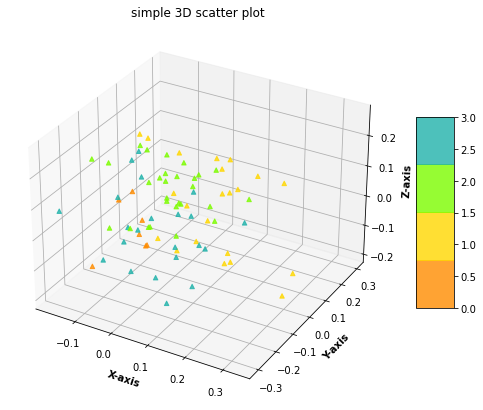

In [101]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

 
# Creating color map
my_cmap = cmap = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"]) # plt.get_cmap('hsv')

# Creating plot
x = merged_df['0']
y = merged_df['1']
z = merged_df['2']
c = merged_df['cluster4']

sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = c, # (x + y + z)
                    cmap = my_cmap,
                    marker ='^')

plt.title("simple 3D scatter plot")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
#ax.azim = 90
#ax.horz = 90
# show plot
plt.show()

## Let's look at Hierarchical Clustering

In [102]:
group0_data = group0.drop(columns=['first_cluster','player','cluster37','cluster4']).values

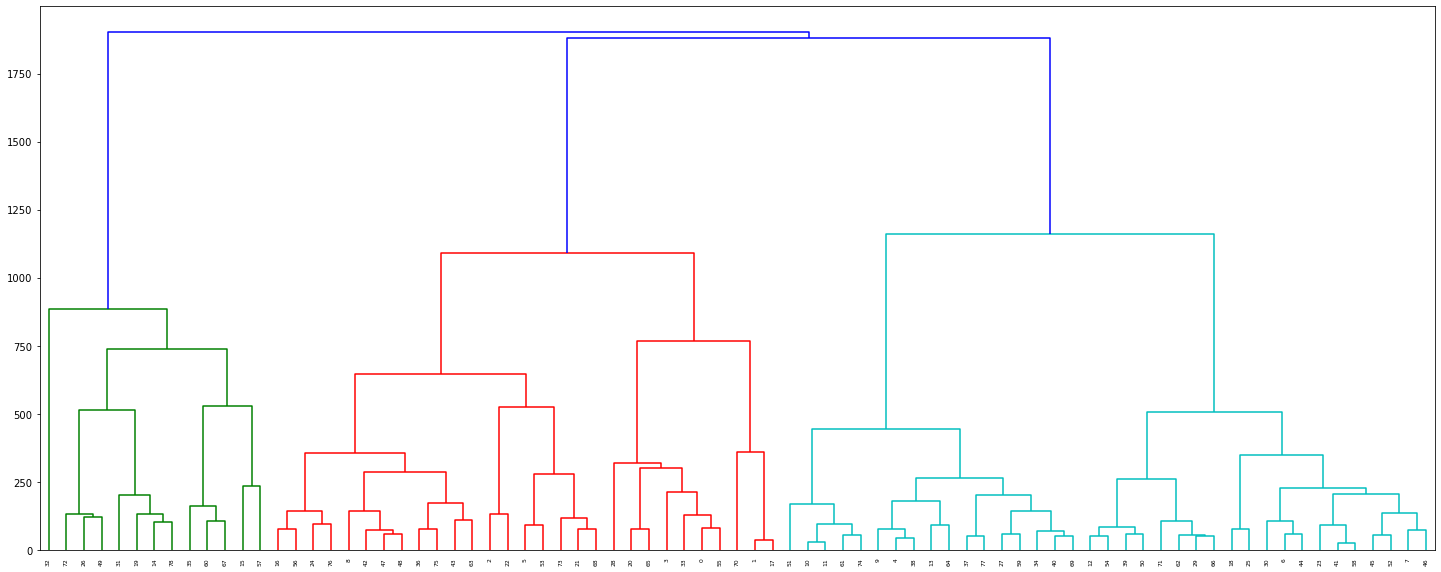

In [103]:
Z = linkage(group0_data, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

plt.show()

Nice!! 3 solid clusters right there baby. Let's try after PCA too just to see. And we've gotta see which players are in which cluster and get separate dfs for them.

In [104]:
group0_data = group0.drop(columns=['first_cluster','player','cluster37','cluster4']).values
group0_data.shape

(79, 24)

In [105]:
scaler = StandardScaler()
scaled_group0_data = scaler.fit_transform(group0_data)

pca = PCA(n_components=3)
pca.fit(scaled_group0_data.transpose())
X_3 = pd.DataFrame(pca.components_).transpose().values
X_3.shape

(79, 3)

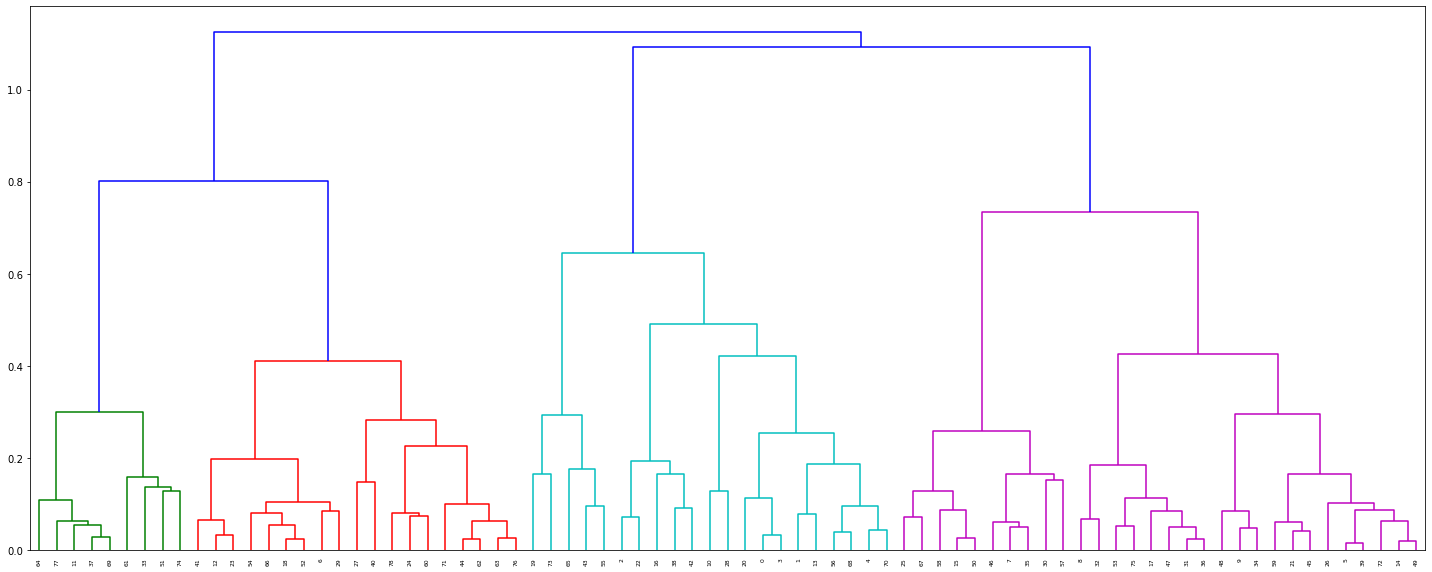

In [106]:
Z_3 = linkage(X_3, 'ward')
fig = plt.figure(figsize=(25, 10))
dn_3 = dendrogram(Z_3)

plt.show()

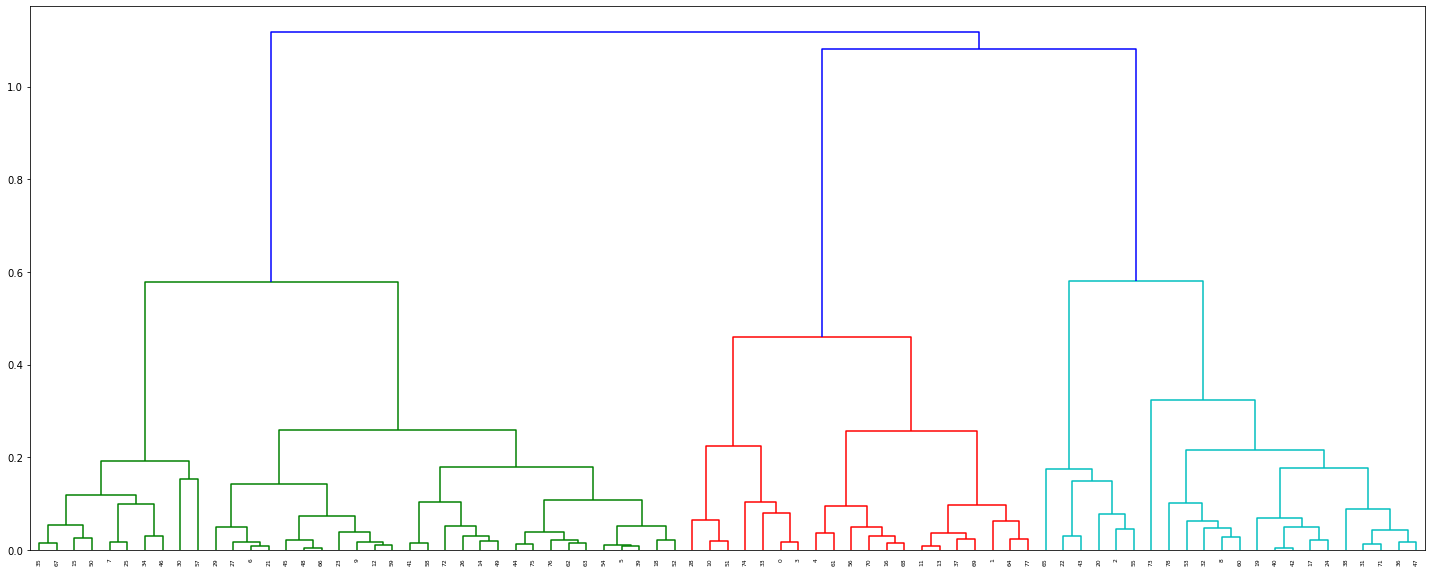

In [107]:
scaler = StandardScaler()
scaled_group0_data = scaler.fit_transform(group0_data)

pca = PCA(n_components=2)
pca.fit(scaled_group0_data.transpose())
X_2 = pd.DataFrame(pca.components_).transpose().values

Z_2 = linkage(X_2, 'ward')
fig = plt.figure(figsize=(25, 10))
dn_2 = dendrogram(Z_2)

plt.show()

In [108]:
dn_2.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [154]:
dn_2['ivl']

['35',
 '67',
 '15',
 '50',
 '7',
 '25',
 '34',
 '46',
 '30',
 '57',
 '29',
 '27',
 '6',
 '21',
 '45',
 '48',
 '66',
 '23',
 '9',
 '12',
 '59',
 '41',
 '58',
 '72',
 '26',
 '14',
 '49',
 '44',
 '75',
 '76',
 '62',
 '63',
 '54',
 '5',
 '39',
 '18',
 '52',
 '28',
 '10',
 '51',
 '74',
 '33',
 '0',
 '3',
 '4',
 '61',
 '56',
 '70',
 '16',
 '68',
 '11',
 '13',
 '37',
 '69',
 '1',
 '64',
 '77',
 '65',
 '22',
 '43',
 '20',
 '2',
 '55',
 '73',
 '78',
 '53',
 '32',
 '8',
 '60',
 '19',
 '40',
 '42',
 '17',
 '24',
 '38',
 '31',
 '71',
 '36',
 '47']

In [110]:
# cophenet(Z, X_2)

### Focusing now on PCA(n=3) clustering

In [111]:
first_index = dn_3['ivl'].index('41')
second_index = dn_3['ivl'].index('19')
third_index = dn_3['ivl'].index('25')

green_ls = dn_3['ivl'][:first_index] # 0
red_ls = dn_3['ivl'][first_index:second_index] # 1
cyan_ls = dn_3['ivl'][second_index:third_index] # 2
purple_ls = dn_3['ivl'][third_index:] # 3

In [126]:
def get_clus(i, green_ls=[], red_ls=[], cyan_ls=[], purple_ls=[]):
    if str(i) in green_ls:
        return 0
    elif str(i) in red_ls:
        return 1
    elif str(i) in cyan_ls:
        return 2
    elif str(i) in purple_ls:
        return 3

In [112]:
group0_new = group0.reset_index().rename(columns={'index':'old_index'})

In [113]:
group0_new #.dropna()

,old_index,4,5,6,7,8,9,10,11,12,...,22,23,24,25,26,27,first_cluster,player,cluster37,cluster4
0,5,25.73,80,33.4,69.5,16.4,12.8,292,0.5,807,...,6.6,1.49,0.96,1.73,7.1,119.9,0,Steven Adams,3,1
1,9,33.73,81,33.2,69.1,27,8.8,412,0.847,1277,...,11.6,0.54,1.32,1.78,9.4,117.8,0,LaMarcus Aldridge,12,3
2,20,24.35,72,32.8,68.2,32.3,14.7,686,0.729,1045,...,30.3,1.26,1.53,3.71,15.5,121.6,0,Giannis Antetokounmpo,15,3
3,28,20.72,71,30.7,64,21.2,11.7,189,0.746,866,...,9.6,0.87,0.94,1.77,8.7,117.7,0,Deandre Ayton,28,1
4,30,20.08,62,25.3,52.7,24.2,10.7,262,0.691,610,...,5.9,0.53,0.95,1.58,7.6,111.1,0,Marvin Bagley III,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,598,29.83,72,23.3,48.4,22.6,10.9,243,0.449,665,...,5.6,0.64,1.89,1.33,8.3,112.4,0,Hassan Whiteside,3,1
75,599,24.13,73,34.8,72.6,24.4,9.4,296,0.699,862,...,10.9,0.97,0.66,1.9,6.9,99.8,0,Andrew Wiggins,14,3
76,605,32.46,75,26.6,55.4,32.5,11.8,484,0.876,847,...,33,0.75,0.15,2.41,10.3,111.8,0,Lou Williams,20,3
77,616,30.8,81,30.7,64,18,12,135,0.644,696,...,12,1.52,0.47,1.52,7.6,113.6,0,Thaddeus Young,31,1


In [114]:
group0_new['agglo_clus'] = group0_new.apply(lambda x: get_clus(x.name, green_ls, red_ls, cyan_ls, purple_ls), axis=1)

In [115]:
#group0 = df2_labeled[df2_labeled['cluster']==0]

In [116]:
group0_new

,old_index,4,5,6,7,8,9,10,11,12,...,23,24,25,26,27,first_cluster,player,cluster37,cluster4,agglo_clus
0,5,25.73,80,33.4,69.5,16.4,12.8,292,0.5,807,...,1.49,0.96,1.73,7.1,119.9,0,Steven Adams,3,1,2
1,9,33.73,81,33.2,69.1,27,8.8,412,0.847,1277,...,0.54,1.32,1.78,9.4,117.8,0,LaMarcus Aldridge,12,3,2
2,20,24.35,72,32.8,68.2,32.3,14.7,686,0.729,1045,...,1.26,1.53,3.71,15.5,121.6,0,Giannis Antetokounmpo,15,3,2
3,28,20.72,71,30.7,64,21.2,11.7,189,0.746,866,...,0.87,0.94,1.77,8.7,117.7,0,Deandre Ayton,28,1,2
4,30,20.08,62,25.3,52.7,24.2,10.7,262,0.691,610,...,0.53,0.95,1.58,7.6,111.1,0,Marvin Bagley III,7,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,598,29.83,72,23.3,48.4,22.6,10.9,243,0.449,665,...,0.64,1.89,1.33,8.3,112.4,0,Hassan Whiteside,3,1,0
75,599,24.13,73,34.8,72.6,24.4,9.4,296,0.699,862,...,0.97,0.66,1.9,6.9,99.8,0,Andrew Wiggins,14,3,3
76,605,32.46,75,26.6,55.4,32.5,11.8,484,0.876,847,...,0.75,0.15,2.41,10.3,111.8,0,Lou Williams,20,3,1
77,616,30.8,81,30.7,64,18,12,135,0.644,696,...,1.52,0.47,1.52,7.6,113.6,0,Thaddeus Young,31,1,0


In [117]:
clus0 = group0_new[group0_new['agglo_clus']==0]
clus1 = group0_new[group0_new['agglo_clus']==1]
clus2 = group0_new[group0_new['agglo_clus']==2]
clus3 = group0_new[group0_new['agglo_clus']==3]

clus0_mean = clus0.mean(axis=0).to_frame().transpose()
clus1_mean = clus1.mean(axis=0).to_frame().transpose() # mean values of each cluster
clus2_mean = clus2.mean(axis=0).to_frame().transpose()
clus3_mean = clus3.mean(axis=0).to_frame().transpose()
means = clus0_mean.append(clus1_mean)
means = means.append(clus2_mean)
means = means.append(clus3_mean)
means = means[[10,12,14,20,22,23,24]]
means.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,FTA,2PA,3PA,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.
0,241.000000,701.000000,87.666667,16.288889,10.633333,0.850000,1.267778
0,264.157895,700.315789,365.736842,7.205263,22.526316,0.913684,0.338421
0,396.857143,874.000000,161.142857,17.414286,19.557143,1.036190,1.167143
0,353.733333,765.866667,458.700000,8.110000,20.860000,1.123000,0.478000


In [131]:
#clus0

In [132]:
#clus1

In [133]:
#clus2

In [134]:
#clus3

In [122]:
# ch_scores.append(ch_score(scaled_vals, cluster_labels))
# db_scores.append(db_score(scaled_vals, cluster_labels))

ch_score(scaled_group0_data, group0_new['agglo_clus'])

11.224325431552625

In [123]:
db_score(scaled_group0_data, group0_new['agglo_clus'])

2.014873451510294

## PCA = 2

In [127]:
first_index = dn_2['ivl'].index('28')
second_index = dn_2['ivl'].index('65')
#third_index = dn_2['ivl'].index('25')

green_ls = dn_2['ivl'][:first_index] # 0
red_ls = dn_2['ivl'][first_index:second_index] # 1
cyan_ls = dn_2['ivl'][second_index:] # 2
#purple_ls = dn_2['ivl'][third_index:] # 3

In [137]:
group0_new2 = group0.reset_index().rename(columns={'index':'old_index'})
group0_new2['agglo_clus'] = group0_new2.apply(lambda x: get_clus(x.name, green_ls, red_ls, cyan_ls), axis=1)

clus0_2 = group0_new2[group0_new2['agglo_clus']==0]
clus1_2 = group0_new2[group0_new2['agglo_clus']==1]
clus2_2 = group0_new2[group0_new2['agglo_clus']==2]
#clus3_2 = group0_new2[group0_new2['agglo_clus']==3]

clus0_2_mean = clus0_2.mean(axis=0).to_frame().transpose()
clus1_2_mean = clus1_2.mean(axis=0).to_frame().transpose() # mean values of each cluster
clus2_2_mean = clus2_2.mean(axis=0).to_frame().transpose()
#clus3_2_mean = clus3_2.mean(axis=0).to_frame().transpose()
means_2 = clus0_mean.append(clus1_2_mean)
means_2 = means_2.append(clus2_2_mean)
#means_2 = means_2.append(clus3_2_mean)
means_2 = means_2[[5,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]] # 4,7,8, ,24,25,26,27
means_2.rename(columns={curr_cols[i]:new_cols[i] for i in range(29)})

,GP,MPG,Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions,FTA,FT%,2PA,2P%,3PA,3P%,"eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA","TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.",PPGPointsPoints per game.,RPGReboundsRebounds per game.,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,APGAssistsAssists per game.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.
0,77.000000,26.922222,11.733333,241.000000,0.657556,701.000000,0.583778,87.666667,0.312111,0.578222,0.596778,13.855556,7.988889,16.288889,1.922222,10.633333,0.850000
0,74.100000,29.415000,11.435000,298.450000,0.694500,792.150000,0.582350,100.850000,0.257350,0.577900,0.603350,16.780000,9.440000,17.215000,2.185000,11.545000,0.854000
0,72.409091,32.718182,14.436364,425.409091,0.749000,867.727273,0.519000,327.454545,0.289727,0.515909,0.560091,21.636364,7.363636,11.995455,5.836364,28.863636,1.204545


In [129]:
ch_score(scaled_group0_data, group0_new2['agglo_clus'])

14.479953255194015

In [130]:
db_score(scaled_group0_data, group0_new2['agglo_clus'])

1.9280290122802537

In [143]:
clus2_2

,old_index,4,5,6,7,8,9,10,11,12,...,23,24,25,26,27,first_cluster,player,cluster37,cluster4,agglo_clus
2,20,24.35,72,32.8,68.2,32.3,14.7,686,0.729,1045,...,1.26,1.53,3.71,15.5,121.6,0,Giannis Antetokounmpo,15,3,2
8,66,22.44,64,35,73,32.9,15.4,454,0.866,841,...,0.88,0.2,4.13,10.3,109.4,0,Devin Booker,5,3,2
17,157,29.68,77,34.9,72.7,27.9,11.6,439,0.831,1268,...,1.12,0.47,2.57,10.6,110,0,DeMar DeRozan,12,3,2
19,164,20.12,72,32.2,67.1,30.5,14.9,485,0.713,672,...,1.08,0.35,3.42,12.4,106.9,0,Luka Doncic,25,2,2
20,170,25.67,79,33.5,69.8,23,12.4,412,0.59,1016,...,1.73,1.76,2.22,8.6,113.1,0,Andre Drummond,0,3,2
22,180,25.07,64,33.7,70.1,33.3,13.3,649,0.804,936,...,0.72,1.91,3.55,13.2,113.7,0,Joel Embiid,30,3,2
24,199,21.31,81,31.4,65.5,24.5,15,417,0.727,870,...,1.64,0.56,2.8,10,109.9,0,De'Aaron Fox,8,3,2
31,234,30.07,75,35,72.8,30.2,13.8,550,0.753,819,...,0.69,0.37,3.37,11.4,112.9,0,Blake Griffin,32,0,2
32,239,29.63,78,36.8,76.6,40.5,14.5,858,0.879,881,...,2.05,0.73,4.96,13.2,118.6,0,James Harden,10,0,2
36,266,28.83,67,35.8,74.7,25.5,14.2,271,0.768,796,...,1.64,0.81,3.16,10.4,110.9,0,Jrue Holiday,6,2,2
